# Maintenir la Segmentation des Clients : Assurer une Pertinence à Long Terme et une Personnalisation Optimale

## Préambule

Dans les deux premiers notebooks, nous avons effectué une Analyse Exploratoire des Données (EDA) approfondie et avons réalisé une segmentation de clients à l'aide de l'algorithme K-Means, DBScan et l'Analyse Hiérarchique Ascendante (CAH). Grâce à ces méthodes, nous avons pu identifier le K-Means comme le meilleur algorithme pour la segmentation des clients du site Olist.

Dans ce notebook, nous allons nous concentrer sur la maintenance de cette segmentation des clients. Pour ce faire, nous allons utiliser un jeu de données propre et sélectionner la date de shopping la plus ancienne comme point de départ. Ensuite, nous allons extraire les données pour la première année à partir de cette date.

L'idée principale de cette étude est de vérifier la stabilité de la segmentation réalisée par K-Means en utilisant les données de la première année comme référence. Pour cela, nous allons entraîner le modèle K-Means avec ces données initiales et les utiliser pour prédire les clusters pour les clients de chaque semaine suivante de cette première année. À chaque itération, nous ajouterons une semaine supplémentaire de données et répéterons le processus de prédiction.

En comparant les résultats des prédictions avec le modèle initial, nous pourrons évaluer la similarité des clusters au fil du temps. Nous utiliserons l'Indice d'Ajustement de Rand (ARI) pour quantifier la cohérence et la stabilité des clusters au fil des semaines.

Cette approche nous permettra de mieux comprendre comment maintenir la segmentation des clients de manière efficace et de prendre des mesures appropriées pour ajuster notre modèle K-Means en fonction de l'évolution des comportements des clients au fil du temps.

In [2]:
# pour editer le jeu de donne
import pandas as pd
import numpy as np
import datetime as dt
import time
from IPython.display import Image
# pour visualiser 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import cufflinks as cf 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import importlib.metadata
from scipy import stats

# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()
%matplotlib inline

In [3]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

In [4]:
!python --version

# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

print("matplotlib - ", importlib.metadata.version('matplotlib'))

Python 3.8.3
pandas - 2.0.3
numpy - 1.23.5
seaborn - 0.12.2
missingno - 0.4.2
cufflinks - 0.17.3
matplotlib -  3.6.2


In [6]:

df = pd.read_csv('df_clean.csv')

In [8]:
display(df.head())


,customer_id,primary_payment,common_payment_count,tot_product,order_id,product_id,order_item_quantity,order_purchase_timestamp,order_purchase_date,year,month,day,hour,days_since_last_order,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,seller_id,price,freight_value,product_category_name,product_category_name_english,main_category_group,seller_zip_code_prefix,seller_city,seller_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00012a2ce6f8dcda20d059ce98491703,credit_card,8.0,1,5f79b5b0931d63f1a42989eb65b9da6e,64315bd8c0c47303179dd2e25b579d00,1,2017-11-14 16:08:26,2017-11-14 16:00:00,2017,Nov,14,16,287,248ffe10d632bebe4f7267f1f44844c9,6273,osasco,SP,1.0,credit_card,8.0,114.74,7aa4334be125fcdd2ba64b3180029f14,89.80,24.94,brinquedos,toys,leisure,18500,laranjal paulista,SP,65645c124061b43b2edc38b05ee76aab,1.0,NaN,Tudo dentro do esperado,2017-11-29 00:00:00,2017-12-04 12:00:07
1,000161a058600d5901f007fab4c27140,credit_card,5.0,1,a44895d095d7e0702b6a162fa2dbeced,84183944dc7cddca87a5d384452c1d3c,1,2017-07-16 09:40:32,2017-07-16 09:00:00,2017,Jul,16,9,409,b0015e09bb4b6e47c52844fab5fb6638,35550,itapecerica,MG,1.0,credit_card,5.0,67.41,2a1348e9addc1af5aaa619b1a3679d6b,54.90,12.51,beleza_saude,health_beauty,beauty and hygiene,30494,belo horizonte,MG,862cae301754fcafa8129022c8eca937,4.0,NaN,NaN,2017-07-26 00:00:00,2017-07-27 18:17:27
2,0001fd6190edaaf884bcaf3d49edf079,credit_card,10.0,1,316a104623542e4d75189bb372bc5f8d,9df2b21ec85378d71df4404712e17478,1,2017-02-28 11:06:43,2017-02-28 11:00:00,2017,Feb,28,11,547,94b11d37cd61cb2994a194d11f89682b,29830,nova venecia,ES,1.0,credit_card,10.0,195.42,46dc3b2cc0980fb8ec44634e21d2718e,179.99,15.43,bebes,baby,baby,22240,rio de janeiro,RJ,238e7cc8c4579a3d4db8f2a211db5b06,5.0,NaN,Muito bom,2017-03-07 00:00:00,2017-03-08 00:23:34
3,0002414f95344307404f0ace7a26f1d5,boleto,1.0,1,5825ce2e88d5346438686b0bba99e5ee,af3ec22cce878225aae6d9eb6c7a78eb,1,2017-08-16 13:09:20,2017-08-16 13:00:00,2017,Aug,16,13,378,4893ad4ea28b2c5b3ddf4e82e79db9e6,39664,mendonca,MG,1.0,boleto,1.0,179.35,aafe36600ce604f205b86b5084d3d767,149.90,29.45,cool_stuff,cool_stuff,leisure,88115,sao jose,SC,c3a9be1f602ecba1c7bdff5639c975fe,5.0,NaN,NaN,2017-09-14 00:00:00,2017-09-15 00:26:09
4,000379cdec625522490c315e70c7a9fb,boleto,1.0,1,0ab7fb08086d4af9141453c91878ed7a,868b3136c5b206f91b8208fbfdf2cb7c,1,2018-04-02 13:42:17,2018-04-02 13:00:00,2018,Apr,2,13,149,0b83f73b19c2019e182fd552c048a22c,4841,sao paulo,SP,1.0,boleto,1.0,107.01,4a3ca9315b744ce9f8e9374361493884,93.00,14.01,cama_mesa_banho,bed_bath_table,home,14940,ibitinga,SP,fab6aa1b4c382a27ae8625faa342c229,4.0,NaN,NaN,2018-04-14 00:00:00,2018-04-16 20:17:51


In [11]:
df['order_purchase_timestamp']

0         2017-11-14 16:08:26
1         2017-07-16 09:40:32
2         2017-02-28 11:06:43
3         2017-08-16 13:09:20
4         2018-04-02 13:42:17
                 ...         
105302    2018-03-29 16:59:26
105303    2018-03-29 16:59:26
105304    2018-05-22 13:36:02
105305    2018-06-13 16:57:05
105306    2017-09-02 11:53:32
Name: order_purchase_timestamp, Length: 105307, dtype: object

In [12]:
print("Date du dernier achat", df.order_purchase_timestamp.max())
print("Date du premier achat", df.order_purchase_timestamp.min())

Date du dernier achat 2018-08-29 15:00:37
Date du premier achat 2016-09-15 12:16:38


La période allant du 15 septembre 2016 à 12h16 au 29 août 2018 à 15h00

In [13]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp']).dt.date


In [16]:
from pandas.tseries.offsets import DateOffset

# Convert the 'order_purchase_timestamp' column to datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format='%Y-%m-%d')

# Get the date one year ago as a Timestamp object
one_year_ago_date = pd.Timestamp(df['order_purchase_timestamp'].min()) + DateOffset(years=1)


In [17]:
one_year_ago_date

Timestamp('2017-09-15 00:00:00')

Après avoir converti la colonne 'order_purchase_timestamp' en format de date, nous avons obtenu la date du 15 septembre 2017, qui correspond à un an après la première consommation sur le site Olist.

Ce code est une fonction qui prend un nombre de jours en entrée et retourne un DataFrame contenant les valeurs RFM mises à l'échelle pour une période spécifiée.

In [21]:
# Importer les modules nécessaires
from sklearn.preprocessing import MinMaxScaler

def customer_dataset(nbdays):
    # Convertir la chaîne de date d'entrée en un objet pandas Timestamp
    date_str = df.order_purchase_timestamp.min() + DateOffset(days=365 + nbdays)
    date = pd.to_datetime(date_str).date()

    # Convertir les dates de commandes en objets date dans le DataFrame
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp']).dt.date

    # Filtrer les données pour inclure uniquement les commandes jusqu'à la date spécifiée (1 an après la date minimale)
    data_ref = df[df['order_purchase_timestamp'] <= date].copy()

    # Calculer la récence, la fréquence et la valeur monétaire pour chaque client.
    # Récence (Recency) : Nombre de jours depuis la dernière commande jusqu'à la date spécifiée.
    # Fréquence (Frequency) : Nombre d'achats uniques pour chaque client jusqu'à la date spécifiée.
    # Valeur monétaire (Monetary) : Somme totale des paiements pour chaque client jusqu'à la date spécifiée.
    df_customers = data_ref.groupby('customer_unique_id').agg(
        recency=('order_purchase_timestamp', lambda x: (date - x.max()).days),
        frequency=("order_id", "nunique"),
        monetary=("payment_value", "sum")
    ).reset_index()

    # Sélectionner les colonnes nécessaires pour le RFM
    selected_columns = ['recency', 'frequency', 'monetary']

    # Appliquer la transformation logarithmique aux colonnes RFM
    # (Recency, Frequency, Monetary) pour mieux répartir les valeurs et réduire les écarts entre les données.
    data_log_transformed = df_customers[selected_columns].apply(lambda x: np.log1p(x))

    # Créer une instance du MinMaxScaler pour mettre à l'échelle les valeurs RFM transformées.
    scaler = MinMaxScaler()

    # Appliquer MinMaxScaler sur les données RFM transformées pour les mettre à l'échelle dans l'intervalle [0, 1].
    data_scaled = scaler.fit_transform(data_log_transformed)

    # Créer un nouveau DataFrame avec les données RFM mises à l'échelle.
    data_scaled_df = pd.DataFrame(data_scaled, columns=selected_columns)

    return data_scaled_df

## Initialisation avec un an de données.

#### Période T0 = 12 mois

Dans cette étape de modélisation, nous allons initialiser notre analyse avec une période de 12 mois de données, que nous appellerons "Période T0". Nous prendrons les données de l'année initiale depuis la première date d'achat jusqu'à une année complète après cette date. Cela nous permettra de construire notre modèle de segmentation client en utilisant les valeurs RFM mises à l'échelle pour cette première année de données.

In [22]:
customer_dataset(0)
 

,recency,frequency,monetary
0,0.888929,0.0,0.493669
1,0.894197,0.0,0.554393
2,0.693647,0.0,0.375762
3,0.607105,0.0,0.499899
4,0.576217,0.0,0.690039
...,...,...,...
23733,0.607105,0.0,0.512832
23734,0.458787,0.0,0.444718
23735,0.780189,0.0,0.920009
23736,0.914535,0.0,0.522727


In [23]:
# Obtenir les données RFM pour le premier intervalle de temps (0 jours)
df_0 = customer_dataset(0)

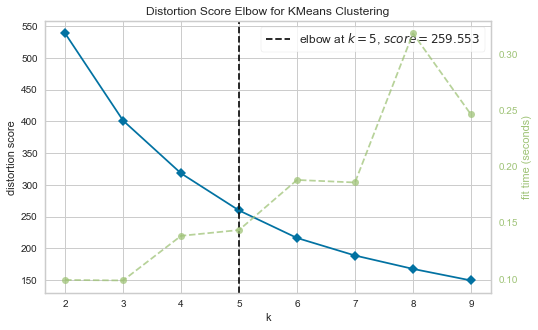

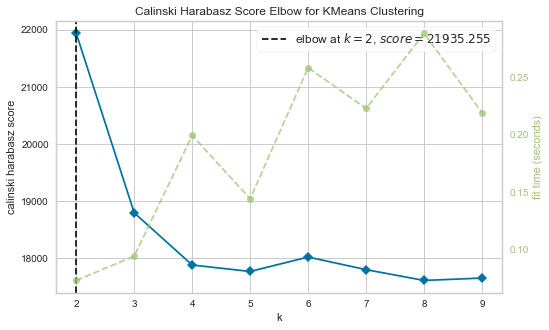

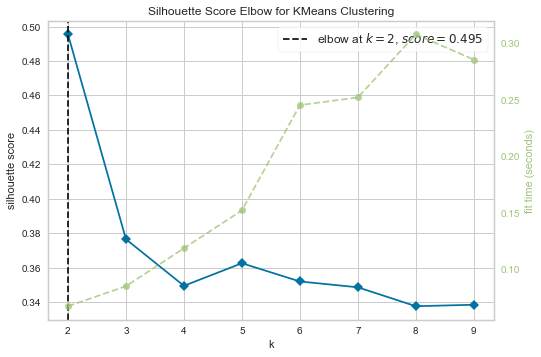

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [42]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance, KElbowVisualizer

# Créer un modèle KMeans avec n_init=10
model = KMeans(n_init=10)


# Visualize the Distortion Score
plt.figure(figsize=(8, 5))
visualizer = KElbowVisualizer(model, k=(2, 10), metric='distortion')
visualizer.fit(df_0)
visualizer.show()

# Visualize the Intercluster Distance
plt.figure(figsize=(8, 5))
visualizer = KElbowVisualizer(model, k=(2, 10), metric='calinski_harabasz')
visualizer.fit(df_0)
visualizer.show()

# Créer un KElbowVisualizer avec la métrique 'silhouette'
visualizer = KElbowVisualizer(model, k=(2, 10), metric='silhouette', timings=True)

# Adapter le visualiseur sur le jeu de données df_0
visualizer.fit(df_0)

# Afficher le graphique
visualizer.poof()


/Users/ismailcanoguz/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



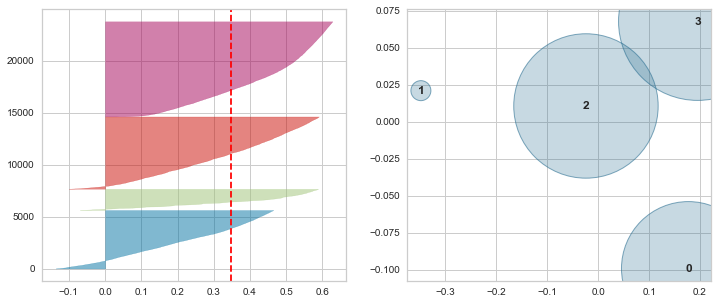

In [41]:
# Initialiser le nombre de clusters à 4
K = 4

# Créer la figure pour les visualisations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Suppression du UserWarning
fig.set_tight_layout(False)

visualizer1 = SilhouetteVisualizer(KMeans(n_clusters=K, n_init=10, random_state=1), ax=axes[0], colors='yellowbrick')
visualizer1.fit(df_0)

visualizer2 = InterclusterDistance(KMeans(n_clusters=K, n_init=10, random_state=1), ax=axes[1], colors='yellowbrick')
visualizer2.fit(df_0)


# Afficher les visualisations
plt.show()

In [43]:

# Nombre de clusters souhaité pour la méthode K-means
k = 4

# Créer un modèle K-means avec les paramètres spécifiés
model_0 = KMeans(n_clusters=k, n_init=10, random_state=1)

# Effectuer la classification K-means sur les données du premier intervalle
model_0.fit(df_0)

KMeans(n_clusters=4, n_init=10, random_state=1)

Le modèle "model_0" servira de base pour nos analyses ultérieures lorsque nous commencerons à incrémenter les données de manière progressive pour étudier l'évolution des segments de clients au fil du temps. Nous allons appliquer le même modèle "model_0" à chaque jeu de données de périodes supplémentaires pour évaluer comment les segments de clients changent avec le temps.

In [44]:
from sklearn.metrics import adjusted_rand_score
# Liste pour stocker les scores de l'Adjusted Rand Index (ARI) pour chaque intervalle de temps
ARI = []

# Boucle pour itérer à travers différents intervalles de temps (de 0 à 750 jours par pas de 30 jours)
for i in range(0, 350, 7):
    # Obtenir les données RFM pour l'intervalle de temps actuel
    df_period_i = customer_dataset(i)

    # Prédire les étiquettes de cluster pour les données de l'intervalle actuel en utilisant le modèle K-means initial
    labels_pred = model_0.predict(df_period_i)

    # Créer un nouveau modèle K-means pour le nouvel intervalle de temps
    model_t = KMeans(n_clusters=k, n_init=10, random_state=1)

    # Effectuer la classification K-means sur les données du nouvel intervalle
    model_t.fit(df_period_i)

    # Prédire les étiquettes de cluster réelles en utilisant le modèle K-means nouvellement entraîné
    labels_true = model_t.predict(df_period_i)

    # Calculer l'Adjusted Rand Index (ARI) entre les étiquettes réelles et prédites
    ari_score = adjusted_rand_score(labels_true, labels_pred)

    # Ajouter le score ARI actuel à la liste ARI
    ARI.append([i, ari_score])

Ce code est utilisé pour évaluer l'évolution des segments de clients au fil du temps à l'aide de l'Adjusted Rand Index (ARI). L'ARI est une mesure de similarité entre deux ensembles d'étiquettes de clusters, où une valeur proche de 1 indique une similitude élevée entre les clusters prédits et réels.


In [45]:
# Extraire les valeurs des temps et des scores ARI à partir de la liste ARI
times, ARI_values = zip(*ARI)

# Créer un graphique pour représenter l'évolution de l'Adjusted Rand Index (ARI) en fonction du temps

# Créer une trace pour le graphique
trace = go.Scatter(x=times, y=ARI_values, mode='markers+lines', marker=dict(size=8), line=dict(width=2))

# Créer la mise en page du graphique
layout = go.Layout(title="Adjusted Rand Index (ARI) au fil du temps",
                   xaxis=dict(title='Temps en jours'),
                   yaxis=dict(title='ARI'))

# Créer la figure du graphique
fig = go.Figure(data=[trace], layout=layout)

# Afficher le graphique
fig.show()


Le graphique montre comment la similarité entre les clusters prédits et réels (mesurée par l'ARI) évolue au fil du temps. En observant ce graphique, nous pouvons analyser comment la stabilité des segments de clients varie au cours des différentes périodes de temps.

Le score ARI initial est de 1.0, ce qui signifie que le modèle K-means initial (model_0) a une correspondance parfaite entre les clusters prédits et réels pour la première période (0-6 jours).

Au fur et à mesure que le temps progresse, le score ARI diminue progressivement, indiquant que la correspondance entre les clusters prédits et réels diminue.

Après 245 jours (environ 8 mois), nous remarquons que l'ARI passe en dessous de 0.5, ce qui indique que la qualité des clusters prédits peut ne pas être suffisante pour représenter fidèlement les groupes de clients à partir de cette période. En conséquence, il est conseillé de vérifier les résultats et d'effectuer des ajustements pour le profil des nouveaux clients après 8 mois.

En outre, nous observons également une diminution de l'ARI après 2-3 mois. Cette baisse pourrait être significative pour comprendre les changements de comportement des clients sur une période plus courte. Il serait donc important de considérer ce changement et d'adapter le profil des nouveaux clients en conséquence.

## Conclusion

Dans cette étude, nous avons utilisé les données de la première année pour initier notre modèle de segmentation des clients avec la méthode K-means. Ensuite, nous avons évalué la stabilité du modèle en augmentant progressivement la période d'analyse et en effectuant des prédictions à chaque pas de temps. L'Adjusted Rand Index (ARI) a été utilisé comme métrique pour mesurer la similarité entre les étiquettes de cluster prédites par le modèle initial et celles prédites par les modèles ultérieurs.  


Les résultats de l'ARI ont montré que le modèle de segmentation était initialement très stable, avec un ARI parfait de 1.0 pour la première période. Cependant, au fil du temps, l'ARI a montré des variations, indiquant que les profils des segments de clients pouvaient évoluer. Cela démontre l'importance de la maintenance régulière du modèle pour s'assurer qu'il reste adapté à l'évolution des préférences des clients.

## Perspective

En regardant vers l'avenir, cette étude nous encourage à explorer davantage de facteurs qui pourraient influencer la stabilité de la segmentation des clients, tels que l'ajout de nouvelles fonctionnalités ou le suivi d'événements spécifiques. De plus, il serait intéressant d'approfondir notre analyse en utilisant d'autres méthodes de clustering et d'évaluer comment elles se comportent par rapport à K-means.

En conclusion, cette étude de maintenance nous a permis de mieux comprendre l'évolution du comportement des clients d'Olist au fil du temps et nous a fourni des informations précieuses pour maintenir la pertinence de la segmentation des clients. Grâce à une approche proactive et adaptable, nous pouvons fournir des expériences personnalisées à nos clients, améliorer leur satisfaction et favoriser une plus grande fidélité envers notre plateforme. Nous sommes impatients de poursuivre nos efforts dans ce domaine et d'explorer de nouvelles pistes pour optimiser encore davantage notre segmentation des clients et offrir des services toujours plus adaptés à leurs besoins.

In [7]:
import plotly.graph_objects as go
import random

# Generate random data
x_values = list(range(1, 11))
y_values = [random.randint(1, 100) for _ in range(10)]

# Create the line plot
fig = go.Figure(data=go.Scatter(x=x_values, y=y_values, mode='lines+markers'))

# Customize the layout if needed
fig.update_layout(title_text='Random Line Plot', xaxis_title='X Axis', yaxis_title='Y Axis')

# Show the plot in Jupyter Notebook
fig.show()


In [19]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()